In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py


In [29]:
#Inflate variant effect predictions from h5 file

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1, 2, 3], fold_suffixes=['', '', '', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []
    
    sed_scores = None

    #Loop over folds
    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        #Load file
        sed = h5py.File('../../../borzoi/examples/saved_models/f3c' + str(fold_ix) + fold_suffix + '/sqtl_span_shift/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat = sed['nDi'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        #Accumulate scores (sum across folds; properly averaged after loop)
        if fold_i == 0 :
            sed_scores = score_mat.copy()
        else :
            sed_scores += score_mat.copy()
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        preds = []
        ref_alleles = []
        alt_alleles = []

        #Loop over SNP rows
        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            #Average prediction across tissues
            preds.append(np.mean(score_mat[i, :]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        #Create dataframe
        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'delta_score' : preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    #Loop over folds and average across
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    #Average tissue-specific scores across folds
    sed_scores /= float(len(df_folds))
    
    df['row_index'] = np.arange(len(df), dtype=np.int32)
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/sqtl_pip90ea/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=4)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split(";SD=")[1].split(";PI=")[0]).astype(int)
    vcf_df['finemap_gene_id'] = vcf_df['INFO'].apply(lambda x: x.split("MT=")[1].split(".")[0])
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("PI=")[1])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'finemap_gene_id', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df, sed_scores

df_snp_pos, scores_pos = inflate_snp_predictions('pos', [0, 1, 2, 3], ['', '', '', ''])
df_snp_neg, scores_neg = inflate_snp_predictions('neg', [0, 1, 2, 3], ['', '', '', ''])

#Rename borzoi VEP score
df_snp_pos = df_snp_pos.rename(columns={'delta_score' : 'delta_score_borzoi'})
df_snp_neg = df_snp_neg.rename(columns={'delta_score' : 'delta_score_borzoi'})


Inflating predictions for 'pos'.
len(df) = 111609
len(df) = 111609
len(df) = 111609
len(df) = 111609
Inflating predictions for 'neg'.
len(df) = 343055
len(df) = 343055
len(df) = 343055
len(df) = 343055


In [30]:
#Inflate pos predictions (original borzoi V2 model)

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1, 2, 3], fold_suffixes=['', '', '', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []
    
    sed_scores = None

    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        sed = h5py.File('/home/jlinder/analysis/bench_sqtl_v2/test_sqtl/f' + str(fold_ix) + 'c0' + fold_suffix + '/sqtl_span/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat = sed['D0'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        if fold_i == 0 :
            sed_scores = score_mat.copy()[:, -89:]
        else :
            sed_scores += score_mat.copy()[:, -89:]
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        preds = []
        ref_alleles = []
        alt_alleles = []

        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            preds.append(np.mean(score_mat[i, -89:]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'delta_score' : preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    sed_scores /= float(len(df_folds))
    
    df['row_index'] = np.arange(len(df), dtype=np.int32)
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/sqtl_pip90ea/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=4)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split(";SD=")[1].split(";PI=")[0]).astype(int)
    vcf_df['finemap_gene_id'] = vcf_df['INFO'].apply(lambda x: x.split("MT=")[1].split(".")[0])
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("PI=")[1])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'finemap_gene_id', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df, sed_scores

df_snp_pos_old, scores_pos_old = inflate_snp_predictions('pos', [0, 1, 2, 3], ['', '', '', ''])
df_snp_neg_old, scores_neg_old = inflate_snp_predictions('neg', [0, 1, 2, 3], ['', '', '', ''])

#Rename borzoi VEP score
df_snp_pos_old = df_snp_pos_old.rename(columns={'delta_score' : 'delta_score_borzoi'})
df_snp_neg_old = df_snp_neg_old.rename(columns={'delta_score' : 'delta_score_borzoi'})


Inflating predictions for 'pos'.
len(df) = 100619
len(df) = 100619
len(df) = 100619
len(df) = 100619
Inflating predictions for 'neg'.
len(df) = 308132
len(df) = 308132
len(df) = 308132
len(df) = 308132


In [31]:
#Compile list of unique GTEx target descriptions / keywords, for track-QTL set matching further down

target_ids = h5py.File('../../../borzoi/examples/saved_models/f3c0/sqtl_span_shift/merge_pos/sed.h5', 'r')['target_ids'][()][-89:]
target_ids = [tid.decode() for tid in target_ids.tolist()]

target_name_dict = pd.read_csv('../../../borzoi/examples/targets_gtex.txt', sep='\t')[['identifier', 'description']].set_index('identifier').to_dict(orient='index')

target_names = []

#Loop over targets
for tid in target_ids :
    target_names.append(target_name_dict[tid]['description'].split("NA:")[1])


In [32]:
#Filter on matched gene

df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg['gene_id_base'] = df_snp_neg['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)


In [33]:
#Filter on matched gene (old)

df_snp_pos_old['gene_id_base'] = df_snp_pos_old['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg_old['gene_id_base'] = df_snp_neg_old['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos_old = df_snp_pos_old.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg_old = df_snp_neg_old.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)


In [34]:
#Join old and new score dataframes

df_snp_pos = df_snp_pos.join(df_snp_pos_old[['snp', 'row_index']].set_index('snp'), on='snp', how='inner', rsuffix='_old').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(df_snp_neg_old[['snp', 'row_index']].set_index('snp'), on='snp', how='inner', rsuffix='_old').copy().reset_index(drop=True)


In [35]:
#Load Pangolin VEPs

pang_pos_df = pd.read_csv('/home/drk/seqnn/analysis/2023/3-1/pang_sqtl/merge_pos.vcf', sep='\t', skiprows=5)
pang_neg_df = pd.read_csv('/home/drk/seqnn/analysis/2023/3-1/pang_sqtl/merge_neg.vcf', sep='\t', skiprows=5)

#Helper function to calculate Pangolin VEP scores
def _calc_pangolin_score(pang_info) :
    
    if 'Pangolin=' not in pang_info :
        return np.nan
    
    ap = pang_info.split('Pangolin=')[1].split('|Warnings:')[0].split('|')
    finemap_gene_id = pang_info.split('MT=')[1].split(".")[0]

    increase, decrease = 0, 0
    gene_found = False
    num_genes = len(ap) // 3
    
    #Loop over genes scored by Pangolin
    for gi in range(num_genes):
        #Match to target gene
        if ap[3*gi].split(".")[0] == finemap_gene_id :
            increase = abs(float(ap[3*gi + 1].split(':')[1]))
            decrease = abs(float(ap[3*gi + 2].split(':')[1]))
            gene_found = True
            break

    #Final score is the absolute value of increase + decrease
    if gene_found :
        return increase + decrease
    
    return np.nan

#Calculate VEP scores
pang_pos_df['delta_score_pangolin'] = pang_pos_df['INFO'].apply(_calc_pangolin_score)
pang_neg_df['delta_score_pangolin'] = pang_neg_df['INFO'].apply(_calc_pangolin_score)

#Filter on non-zero predictions
pang_pos_df = pang_pos_df.loc[~pang_pos_df['delta_score_pangolin'].isnull()].copy().reset_index(drop=True)
pang_neg_df = pang_neg_df.loc[~pang_neg_df['delta_score_pangolin'].isnull()].copy().reset_index(drop=True)

#Augment main dataframes with Pangolin predictions
df_snp_pos = df_snp_pos.join(pang_pos_df[['ID', 'delta_score_pangolin']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(pang_neg_df[['ID', 'delta_score_pangolin']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)

print("len(df_snp_pos) = " + str(len(df_snp_pos)))
print("len(df_snp_neg) = " + str(len(df_snp_neg)))


len(df_snp_pos) = 4105
len(df_snp_neg) = 16121


In [36]:
#Compute average Pangolin & Borzoi rank

df_snp_pos['pos_neg'] = 'pos'
df_snp_neg['pos_neg'] = 'neg'

df_snp = pd.concat([df_snp_pos, df_snp_neg])

#Calculate Borzoi ranks
df_snp['borzoi_rank'] = np.argsort(np.argsort(df_snp['delta_score_borzoi'].values))
df_snp['borzoi_rank'] /= len(df_snp)

#Calculate Pangolin ranks
df_snp['pangolin_rank'] = np.argsort(np.argsort(df_snp['delta_score_pangolin'].values))
df_snp['pangolin_rank'] /= len(df_snp)

avg_ranks = []

#Loop over SNPs
for _, row in df_snp.iterrows() :
    
    #Calculate average rank
    rank_val = (row['borzoi_rank'] + row['pangolin_rank']) / 2.
    avg_ranks.append(rank_val)

df_snp['delta_score_pangolin_and_borzoi'] = avg_ranks

#Separate dataframe in positives and negatives
df_snp_pos = df_snp.query("pos_neg == 'pos'").copy().reset_index(drop=True)
df_snp_neg = df_snp.query("pos_neg == 'neg'").copy().reset_index(drop=True)


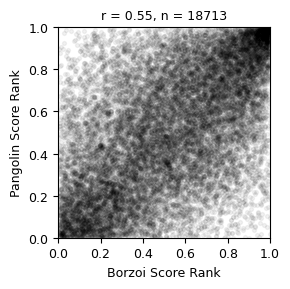

In [37]:
#Compare A2+Saluki and Borzoi ranks

import matplotlib.pyplot as plt
from scipy.stats import spearmanr

filter_query = "min_dist <= 2000"

df_filtered = df_snp.query(filter_query)

r_val = spearmanr(df_filtered['borzoi_rank'], df_filtered['pangolin_rank'])[0]

f = plt.figure(figsize=(3, 3))

plt.scatter(df_filtered['borzoi_rank'], df_filtered['pangolin_rank'], s=8, color='black', alpha=0.05)

plt.title("r = " + str(round(r_val, 2)) + ", n = " + str(len(df_filtered)), fontsize=9)

plt.xlabel("Borzoi Score Rank", fontsize=9)
plt.ylabel("Pangolin Score Rank", fontsize=9)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=9)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=9)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

plt.show()


In [38]:
#Sort by SNP

df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)

#Copy pooled dataframes
df_snp_pos_pooled = df_snp_pos.copy().reset_index(drop=True)
df_snp_neg_pooled = df_snp_neg.copy().reset_index(drop=True)


In [39]:
#Split SNPs into tissues

min_n = 100

#Define tissues
tissue_names = [
    ['adipose_subcutaneous', 'adipose_tissue', 'darkgreen'],
    ['adipose_visceral', 'adipose_tissue', 'darkgreen'],
    ['adrenal_gland', 'adrenal_gland', 'teal'],
    ['artery_aorta', 'blood_vessel', 'darkred'],
    ['artery_coronary', 'blood_vessel', 'darkred'],
    ['artery_tibial', 'blood_vessel', 'darkred'],
    ['blood', 'blood', 'red'],
    ['brain_amygdala', 'brain', 'gold'],
    ['brain_anterior_cingulate_cortex', 'brain', 'gold'],
    ['brain_caudate', 'brain', 'gold'],
    ['brain_cerebellar_hemisphere', 'brain', 'gold'],
    ['brain_cerebellum', 'brain', 'gold'],
    ['brain_cortex', 'brain', 'gold'],
    ['brain_frontal_cortex', 'brain', 'gold'],
    ['brain_hippocampus', 'brain', 'gold'],
    ['brain_hypothalamus', 'brain', 'gold'],
    ['brain_nucleus_accumbens', 'brain', 'gold'],
    ['brain_putamen', 'brain', 'gold'],
    ['brain_spinal_cord', 'brain', 'gold'],
    ['brain_substantia_nigra', 'brain', 'gold'],
    ['breast', 'breast', 'magenta'],
    ['colon_sigmoid', 'colon', 'brown'],
    ['colon_transverse', 'colon','brown'],
    ['esophagus_gej', 'esophagus', 'darkblue'],
    ['esophagus_mucosa', 'esophagus', 'darkblue'],
    ['esophagus_muscularis', 'esophagus', 'darkblue'],
    ['fibroblast', 'skin', 'burlywood'],
    ['heart_atrial_appendage', 'heart', 'darkred'],
    ['heart_left_ventricle', 'heart', 'darkred'],
    ['kidney_cortex', 'kidney', 'saddlebrown'],
    ['LCL', 'blood', 'red'],
    ['liver', 'liver', 'violet'],
    ['lung', 'lung', 'gray'],
    ['minor_salivary_gland', 'salivary_gland', 'orange'],
    ['muscle', 'muscle', 'black'],
    ['nerve_tibial', 'nerve', 'red'],
    ['ovary', 'ovary', 'magenta'],
    ['pancreas', 'pancreas', 'brown'],
    ['pituitary', 'pituitary', 'brown'],
    ['prostate', 'prostate', 'darkblue'],
    ['skin_not_sun_exposed', 'skin', 'burlywood'],
    ['skin_sun_exposed', 'skin', 'burlywood'],
    ['small_intestine', 'small_intestine', 'brown'],
    ['spleen', 'spleen', 'darkviolet'],
    ['stomach', 'stomach', 'brown'],
    ['testis', 'testis', 'darkblue'],
    ['thyroid', 'thyroid', 'lightgray'],
    ['uterus', 'uterus', 'magenta'],
    ['vagina', 'vagina', 'magenta']
]

tissue_dict = {}

#Loop over unique tissues
for [tissue_name, target_name, _] in tissue_names :
    
    #Load tissue-specific VCF file
    vcf_df_pos = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/sqtl_pip90ea/GTEx_txrev_' + tissue_name + '_pos.vcf', sep='\t', skiprows=4)
    vcf_df_neg = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/sqtl_pip90ea/GTEx_txrev_' + tissue_name + '_neg.vcf', sep='\t', skiprows=4)
    
    print("-- " + tissue_name + " --")
    print("len(vcf_df_pos) = " + str(len(vcf_df_pos)))
    print("len(vcf_df_neg) = " + str(len(vcf_df_neg)))
    
    tissue_dict[tissue_name] = {}
    
    #Join main SNP dataframe against tissue-specific VCF in order to filter on valid list of SNP IDs
    tissue_dict[tissue_name]['pos'] = df_snp_pos.join(vcf_df_pos[['ID']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    tissue_dict[tissue_name]['neg'] = df_snp_neg.join(vcf_df_neg[['ID']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    #Select unique matched IDs
    tissue_dict[tissue_name]['pos'] = tissue_dict[tissue_name]['pos'].drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
    tissue_dict[tissue_name]['neg'] = tissue_dict[tissue_name]['neg'].drop_duplicates(subset=['matched_snp'], keep='first').copy().reset_index(drop=True)

    tissue_dict[tissue_name]['pos'] = tissue_dict[tissue_name]['pos'].loc[tissue_dict[tissue_name]['pos']['snp'].isin(tissue_dict[tissue_name]['neg']['matched_snp'])].copy().reset_index(drop=True)
    tissue_dict[tissue_name]['neg'] = tissue_dict[tissue_name]['neg'].loc[tissue_dict[tissue_name]['neg']['matched_snp'].isin(tissue_dict[tissue_name]['pos']['snp'])].copy().reset_index(drop=True)
    
    #Get output track indices for the tissue of interest
    target_index = [i for i in range(len(target_names)) if target_names[i] == target_name]
    
    #Calculate Borzoi VEP score by averaging across tissue replicate tracks (pos)
    delta_score_borzoi_pos = []
    for _, row in tissue_dict[tissue_name]['pos'].iterrows() :
        delta_score_borzoi_pos.append(np.mean(scores_pos[row['row_index'], target_index]))
    
    #Calculate Borzoi VEP score by averaging across tissue replicate tracks (neg)
    delta_score_borzoi_neg = []
    for _, row in tissue_dict[tissue_name]['neg'].iterrows() :
        delta_score_borzoi_neg.append(np.mean(scores_neg[row['row_index'], target_index]))
    
    tissue_dict[tissue_name]['pos']['delta_score_borzoi'] = delta_score_borzoi_pos
    tissue_dict[tissue_name]['neg']['delta_score_borzoi'] = delta_score_borzoi_neg
    
    #Calculate Borzoi VEP score by averaging across tissue replicate tracks (pos; old)
    delta_score_borzoi_pos_old = []
    for _, row in tissue_dict[tissue_name]['pos'].iterrows() :
        delta_score_borzoi_pos_old.append(np.mean(scores_pos_old[row['row_index_old'], target_index]))
    
    #Calculate Borzoi VEP score by averaging across tissue replicate tracks (neg; old)
    delta_score_borzoi_neg_old = []
    for _, row in tissue_dict[tissue_name]['neg'].iterrows() :
        delta_score_borzoi_neg_old.append(np.mean(scores_neg_old[row['row_index_old'], target_index]))
    
    tissue_dict[tissue_name]['pos']['delta_score_borzoi_old'] = delta_score_borzoi_pos_old
    tissue_dict[tissue_name]['neg']['delta_score_borzoi_old'] = delta_score_borzoi_neg_old
    
    #Compute average Borzoi and Panoglin rank
    tissue_dict[tissue_name]['pos']['pos_neg'] = 'pos'
    tissue_dict[tissue_name]['neg']['pos_neg'] = 'neg'

    df_snp = pd.concat([tissue_dict[tissue_name]['pos'], tissue_dict[tissue_name]['neg']])

    #Re-calculate Borzoi ranks
    df_snp['borzoi_rank'] = np.argsort(np.argsort(df_snp['delta_score_borzoi'].values))
    df_snp['borzoi_rank'] /= len(df_snp)

    #Re-calculate Pangolin ranks
    df_snp['pangolin_rank'] = np.argsort(np.argsort(df_snp['delta_score_pangolin'].values))
    df_snp['pangolin_rank'] /= len(df_snp)

    avg_ranks = []
    
    #Loop over SNPs
    for _, row in df_snp.iterrows() :

        #Calculate average rank
        rank_val = (row['borzoi_rank'] + row['pangolin_rank']) / 2.
        avg_ranks.append(rank_val)

    df_snp['delta_score_pangolin_and_borzoi'] = avg_ranks

    tissue_dict[tissue_name]['pos'] = df_snp.query("pos_neg == 'pos'").copy().reset_index(drop=True)
    tissue_dict[tissue_name]['neg'] = df_snp.query("pos_neg == 'neg'").copy().reset_index(drop=True)
    
    #Filter NaNs
    tissue_dict[tissue_name]['pos'] = tissue_dict[tissue_name]['pos'].loc[~tissue_dict[tissue_name]['pos']['delta_score_borzoi'].isnull()].copy().reset_index(drop=True)
    tissue_dict[tissue_name]['neg'] = tissue_dict[tissue_name]['neg'].loc[~tissue_dict[tissue_name]['neg']['delta_score_borzoi'].isnull()].copy().reset_index(drop=True)

    tissue_dict[tissue_name]['pos'] = tissue_dict[tissue_name]['pos'].loc[~tissue_dict[tissue_name]['pos']['delta_score_pangolin'].isnull()].copy().reset_index(drop=True)
    tissue_dict[tissue_name]['neg'] = tissue_dict[tissue_name]['neg'].loc[~tissue_dict[tissue_name]['neg']['delta_score_pangolin'].isnull()].copy().reset_index(drop=True)
    
    print("- n pos (kept) = " + str(len(tissue_dict[tissue_name]['pos'])))
    print("- n neg (kept) = " + str(len(tissue_dict[tissue_name]['neg'])))
    
    if len(tissue_dict[tissue_name]['pos']) < min_n :
        del tissue_dict[tissue_name]
        
        print("[filtered]")

#Filter tissue names
tissue_names = [tissue_names[tissue_i] for tissue_i in range(len(tissue_names)) if tissue_names[tissue_i][0] in tissue_dict]


-- adipose_subcutaneous --
len(vcf_df_pos) = 942
len(vcf_df_neg) = 942
- n pos (kept) = 837
- n neg (kept) = 837
-- adipose_visceral --
len(vcf_df_pos) = 641
len(vcf_df_neg) = 641
- n pos (kept) = 588
- n neg (kept) = 588
-- adrenal_gland --
len(vcf_df_pos) = 317
len(vcf_df_neg) = 317
- n pos (kept) = 287
- n neg (kept) = 287
-- artery_aorta --
len(vcf_df_pos) = 548
len(vcf_df_neg) = 548
- n pos (kept) = 502
- n neg (kept) = 502
-- artery_coronary --
len(vcf_df_pos) = 271
len(vcf_df_neg) = 271
- n pos (kept) = 248
- n neg (kept) = 248
-- artery_tibial --
len(vcf_df_pos) = 848
len(vcf_df_neg) = 848
- n pos (kept) = 751
- n neg (kept) = 751
-- blood --
len(vcf_df_pos) = 540
len(vcf_df_neg) = 540
- n pos (kept) = 511
- n neg (kept) = 511
-- brain_amygdala --
len(vcf_df_pos) = 95
len(vcf_df_neg) = 95
- n pos (kept) = 89
- n neg (kept) = 89
[filtered]
-- brain_anterior_cingulate_cortex --
len(vcf_df_pos) = 135
len(vcf_df_neg) = 135
- n pos (kept) = 126
- n neg (kept) = 126
-- brain_caudate 

min_dist <= 10000
 - n = 4105
min_dist <= 2000
 - n = 3675
min_dist <= 500
 - n = 2714
min_dist <= 200
 - n = 2093
min_dist <= 100
 - n = 1713
min_dist <= 50
 - n = 1300


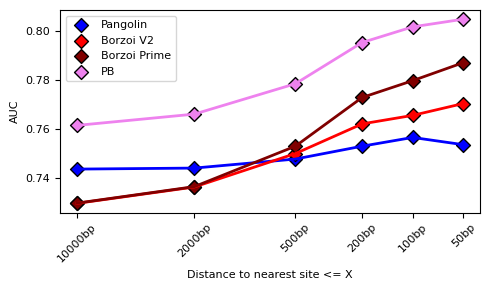

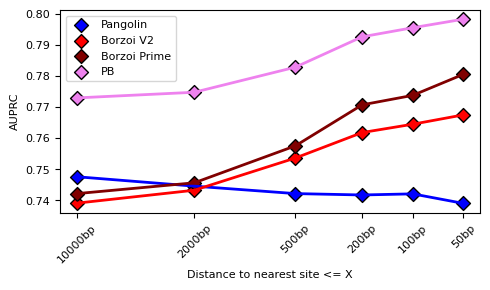

In [40]:
#Evaluate SNP classification performance based on scalar effect size predictions, as a function of SNP-PAS distance

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import seaborn as sns

min_distances = [10000, 2000, 500, 200, 100, 50]

#Define models to compare
score_names = ['delta_score_pangolin', 'delta_score_borzoi_old', 'delta_score_borzoi', 'delta_score_pangolin_and_borzoi']
model_names = ['Pangolin', 'Borzoi V2', 'Borzoi Prime', 'PB']
model_colors = ['blue', 'red', 'maroon', 'violet']

auc_mat = np.zeros((len(min_distances), len(score_names), len(tissue_names)))
ap_mat = np.zeros((len(min_distances), len(score_names), len(tissue_names)))

prcs = []
recs = []

n_mat = np.zeros(len(min_distances), dtype='int32')

#Loop over distance thresholds
for min_dist_ix, min_dist in enumerate(min_distances) :

    print("min_dist <= " + str(min_dist))
    
    #Calculate total number of SNPs within distance threshold
    n_mat[min_dist_ix] = len(df_snp_pos_pooled.query("min_dist <= " + str(min_dist)))
    
    print(" - n = " + str(n_mat[min_dist_ix]))
    
    tissue_prcs = []
    tissue_recs = []

    #Loop over tissues
    for tissue_ix, [tissue_name, _, _] in enumerate(tissue_names) :

        df_snp_pos = tissue_dict[tissue_name]['pos']
        df_snp_neg = tissue_dict[tissue_name]['neg']

        df_snp_pos['is_causal'] = 1
        df_snp_neg['is_causal'] = 0

        #Filter dataframe on distance to nearest site
        filter_query = "min_dist <= " + str(min_dist)

        df_snp_pos_filtered = df_snp_pos.query(filter_query)
        df_snp_neg_filtered = df_snp_neg.query(filter_query)

        #Concat positives and negatives
        df_snp = pd.concat([df_snp_pos_filtered, df_snp_neg_filtered])
        
        model_prcs = []
        model_recs = []

        #Loop over models
        for model_ix, score_name, in enumerate(score_names) :

            score = np.abs(np.array(df_snp[score_name].values))
            distance = -np.abs(np.array(df_snp['min_dist'].values))
            label = np.array(df_snp['is_causal'].values)

            #AUC score
            auc = roc_auc_score(label, score)

            #Precision-recall scores
            ap = average_precision_score(label, score)

            auc_mat[min_dist_ix, model_ix, tissue_ix] = auc
            ap_mat[min_dist_ix, model_ix, tissue_ix] = ap
            
            prc, rec, _ = precision_recall_curve(label, score)
            
            model_prcs.append(prc)
            model_recs.append(rec)
        
        tissue_prcs.append(model_prcs)
        tissue_recs.append(model_recs)
    
    prcs.append(tissue_prcs)
    recs.append(tissue_recs)

import seaborn as sns

#Plot AUC trajectories
auc_mat_r = auc_mat

f = plt.figure(figsize=(5, 3))

for j in range(auc_mat_r.shape[1]) :
    plt.scatter(np.log10(np.array(min_distances)), np.mean(auc_mat_r[:, j, :], axis=-1), s=50, marker='D', color=model_colors[j], edgecolor='black', linewidth=1, label=model_names[j])
    plt.plot(np.log10(np.array(min_distances)), np.mean(auc_mat_r[:, j, :], axis=-1), color=model_colors[j], linewidth=2)

plt.legend(fontsize=8)

plt.xticks(np.log10(min_distances), [str(min_distances[k]) + "bp" for k in range(len(min_distances))], fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest site <= X", fontsize=8)
plt.ylabel("AUC", fontsize=8)

plt.xlim(np.max(np.log10(min_distances))+0.025*np.max(np.log10(min_distances)), np.min(np.log10(min_distances))-0.025*np.max(np.log10(min_distances)))

plt.tight_layout()

plt.show()

#Plot AUPRC trajectories
ap_mat_r = ap_mat

f = plt.figure(figsize=(5, 3))

for j in range(ap_mat_r.shape[1]) :
    plt.scatter(np.log10(np.array(min_distances)), np.mean(ap_mat_r[:, j, :], axis=-1), s=50, marker='D', color=model_colors[j], edgecolor='black', linewidth=1, label=model_names[j])
    plt.plot(np.log10(np.array(min_distances)), np.mean(ap_mat_r[:, j, :], axis=-1), color=model_colors[j], linewidth=2)

plt.legend(fontsize=8)

plt.xticks(np.log10(min_distances), [str(min_distances[k]) + "bp" for k in range(len(min_distances))], fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest site <= X", fontsize=8)
plt.ylabel("AUPRC", fontsize=8)

plt.xlim(np.max(np.log10(min_distances))+0.025*np.max(np.log10(min_distances)), np.min(np.log10(min_distances))-0.025*np.max(np.log10(min_distances)))

plt.tight_layout()

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


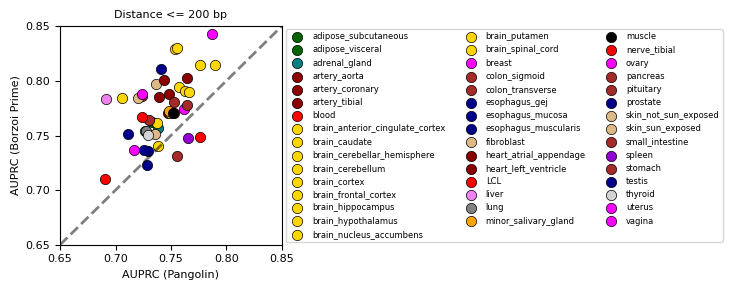

In [42]:
#Compare classification performance between models, per tissue (scatter plot)

model_ix_1 = 0
model_ix_2 = 2

#Distance <= 200 bp
dist_ix = 4

f = plt.figure(figsize=(7.5, 3))

#Loop over tissues
for tissue_ix, [tissue_name, _, tissue_color] in enumerate(tissue_names) :
    plt.scatter([ap_mat[dist_ix, model_ix_1, tissue_ix]], [ap_mat[dist_ix, model_ix_2, tissue_ix]], s=55, linewidth=0.5, edgecolor='black', label=tissue_name, color=tissue_color)

plt.plot([0.65, 0.85], [0.65, 0.85], linewidth=2, linestyle='--', color='black', alpha=0.5)

plt.xlim(0.65, 0.85)
plt.ylim(0.65, 0.85)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("AUPRC (" + model_names[model_ix_1] + ")", fontsize=8)
plt.ylabel("AUPRC (" + model_names[model_ix_2] + ")", fontsize=8)

plt.title("Distance <= 200 bp", fontsize=8)

plt.legend(loc='center left', ncol=3, bbox_to_anchor=(1, 0.5), fontsize=6)

plt.tight_layout()

plt.savefig("borzoi_sqtl_v4_ap_scatter_200_pangolin.png", transparent=False, dpi=300)
plt.savefig("borzoi_sqtl_v4_ap_scatter_200_pangolin.eps")

plt.show()


0.7644397691574771
0.773712331803748


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


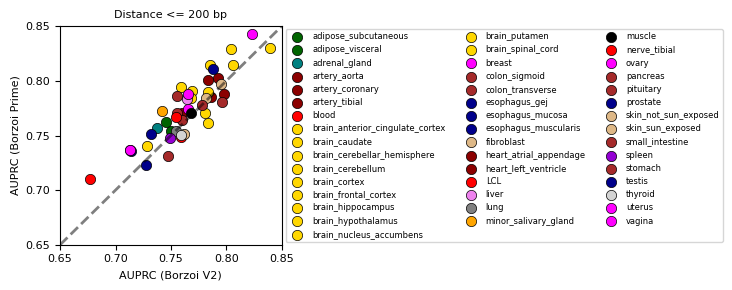

In [43]:
#Compare classification performance between models, per tissue (scatter plot)

model_ix_1 = 1
model_ix_2 = 2

#Distance <= 200 bp
dist_ix = 4

print(np.mean(ap_mat[dist_ix, model_ix_1, :]))
print(np.mean(ap_mat[dist_ix, model_ix_2, :]))

f = plt.figure(figsize=(7.5, 3))

#Loop over tissues
for tissue_ix, [tissue_name, _, tissue_color] in enumerate(tissue_names) :
    plt.scatter([ap_mat[dist_ix, model_ix_1, tissue_ix]], [ap_mat[dist_ix, model_ix_2, tissue_ix]], s=55, linewidth=0.5, edgecolor='black', label=tissue_name, color=tissue_color)

plt.plot([0.65, 0.85], [0.65, 0.85], linewidth=2, linestyle='--', color='black', alpha=0.5)

plt.xlim(0.65, 0.85)
plt.ylim(0.65, 0.85)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("AUPRC (" + model_names[model_ix_1] + ")", fontsize=8)
plt.ylabel("AUPRC (" + model_names[model_ix_2] + ")", fontsize=8)

plt.title("Distance <= 200 bp", fontsize=8)

plt.legend(loc='center left', ncol=3, bbox_to_anchor=(1, 0.5), fontsize=6)

plt.tight_layout()

plt.savefig("borzoi_sqtl_v4_ap_scatter_200_borzoi.png", transparent=False, dpi=300)
plt.savefig("borzoi_sqtl_v4_ap_scatter_200_borzoi.eps")

plt.show()
